# Performance du modèle sans feature engineering et avec donées avec feature engineering

### Dans cette partie, on souhaiterait évaluer l'impact des variables créés lors du feature engineering en prédiction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold,GroupKFold
import datetime
import sklearn
import gc
import joblib
from sklearn import  linear_model
from sklearn.metrics import mean_squared_error
from math import sqrt
from tqdm import tqdm
import pandas as pd

### Données après  feature engineering

In [ ]:
train_df=pd.read_csv('/content/drive/MyDrive/train_preprocessed2.csv')


### Données sans feature engineering mais les données sont prétraitées, remplissage de weather, ..

In [ ]:
train_df_default =pd.read_csv('/content/drive/MyDrive/train_preprocessed99.csv')

### Réduction de mémoires

In [ ]:
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
train_df = reduce_mem_usage(train_df)
train_df_default = reduce_mem_usage(train_df_default)

Memory usage of dataframe is 872.46 MB
Memory usage after optimization is: 312.63 MB
Decreased by 64.2%
Memory usage of dataframe is 581.64 MB
Memory usage after optimization is: 210.85 MB
Decreased by 63.7%


In [ ]:
train_df_default.head()

,Unnamed: 0,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,dew_temperature,wind_speed
0,45,46,0,53.239700,0,11,9045,2016.0,20.0,0.0
1,72,74,0,43.001301,0,8,387638,1997.0,20.0,0.0
2,91,93,0,52.420601,0,6,33370,1982.0,20.0,0.0
3,106,107,0,175.184006,1,0,97532,2005.0,2.4,3.1
4,107,108,0,91.265297,1,0,81580,1913.0,2.4,3.1


In [ ]:
train_df=train_df.drop(['Unnamed: 0','year_built'], axis=1)

In [ ]:
train_df_default = train_df_default.drop(['Unnamed: 0','year_built'], axis=1)

In [ ]:
train_df_default.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,dew_temperature,wind_speed
0,46,0,53.239700,0,11,9045,20.0,0.0
1,74,0,43.001301,0,8,387638,20.0,0.0
2,93,0,52.420601,0,6,33370,20.0,0.0
3,107,0,175.184006,1,0,97532,2.4,3.1
4,108,0,91.265297,1,0,81580,2.4,3.1


## Modèle sur les données sans feature engineering:     
* Baseline                              
* Regression tree

### On split données

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = train_df_default.drop(['meter_reading'], axis=1)
y = train_df_default['meter_reading']

In [ ]:
train, test, y_train, y_test = train_test_split(X, y, test_size=0.36, random_state=42)

## Random model: Baseline

In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(
        np.mean(
            np.square(y_true - y_pred)
        )
    )

In [ ]:
baseline_guess = np.median(y_train)
print('The baseline guess is a score of %0.2f' % baseline_guess)
print("Baseline Performance on the valid set: RMSE = %0.4f" % rmse(y_test, baseline_guess))

The baseline guess is a score of 82.37
Baseline Performance on the valid set: RMSE = 795.7608


### DecisionTreeRegressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
max_depth = [3,5,10,50,100] 
cv_log_error_array=[]
for i in tqdm(max_depth):
    regressor = DecisionTreeRegressor(max_depth=i)
    regressor.fit(train,y_train)
    predict_y =  regressor.predict(test)
    cv_log_error_array.append(sqrt(mean_squared_error(y_test, predict_y)))
for i in range(len(cv_log_error_array)):
    print ('rmse for max_depth and min_sample_split = ',max_depth[i],'is',cv_log_error_array[i])

100%|██████████| 5/5 [01:53<00:00, 22.71s/it]

rmse for max_depth and min_sample_split =  3 is 641.553809669388
rmse for max_depth and min_sample_split =  5 is 506.8128652582777
rmse for max_depth and min_sample_split =  10 is 339.03156487740245
rmse for max_depth and min_sample_split =  50 is 342.71830495676653
rmse for max_depth and min_sample_split =  100 is 342.76509974783426


**On remarque que la plus petite RMSE est 339.031**

2


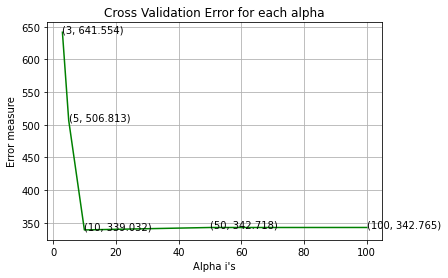

In [ ]:
best_alpha = np.argmin(cv_log_error_array)
print(best_alpha)
fig, ax = plt.subplots()
ax.plot(max_depth, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((max_depth[i],np.round(txt,3)), (max_depth[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

## Modèle sur les données avec feature engineering:     
* Baseline                              
* Regression tree

## on split nos données

In [ ]:
train=train_df[train_df['group_x'] != 3]
test=train_df[train_df['group_x'] == 3]


In [ ]:
y_test=test['meter_reading']
y_train=train['meter_reading']
test= test.drop(['meter_reading'], axis=1)
train = train.drop(['meter_reading'], axis=1)

## Random model: Baseline

In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(
        np.mean(
            np.square(y_true - y_pred)
        )
    )

In [ ]:
baseline_guess = np.median(y_train)
print('The baseline guess is a score of %0.2f' % baseline_guess)
print("Baseline Performance on the valid set: RMSE = %0.4f" % rmse(y_test, baseline_guess))

The baseline guess is a score of 4.41
Baseline Performance on the valid set: RMSE = 1.9536


### DecisionTreeRegressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
max_depth = [3,5,10,50,100] 
cv_log_error_array=[]
for i in tqdm(max_depth):
    regressor = DecisionTreeRegressor(max_depth=i)
    regressor.fit(train,y_train)
    predict_y =  regressor.predict(test)
    cv_log_error_array.append(sqrt(mean_squared_error(y_test, predict_y)))
for i in range(len(cv_log_error_array)):
    print ('rmse for max_depth and min_sample_split = ',max_depth[i],'is',cv_log_error_array[i])

100%|██████████| 5/5 [03:13<00:00, 38.66s/it]

rmse for max_depth and min_sample_split =  3 is 1.6336700448326715
rmse for max_depth and min_sample_split =  5 is 1.4573678542473683
rmse for max_depth and min_sample_split =  10 is 1.0869891254085053
rmse for max_depth and min_sample_split =  50 is 1.1715841056203204
rmse for max_depth and min_sample_split =  100 is 1.1678372143266738


**La plus petite RMSE est 1.086**

**On voit l'avantage de faire du feature engineering**

2


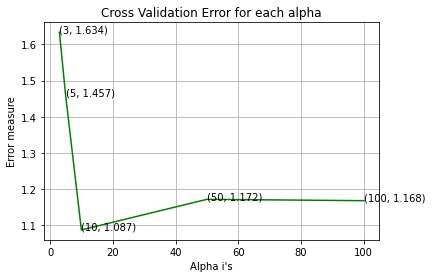

In [ ]:
best_alpha = np.argmin(cv_log_error_array)
print(best_alpha)
fig, ax = plt.subplots()
ax.plot(max_depth, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((max_depth[i],np.round(txt,3)), (max_depth[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()